In [2]:
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import transform as tf
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import cv2

from LFWDataset import LFWDataset
# from SiameseNet import SiameseNet
from p1a import data_aug

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), stride=(2,2)),

            nn.Conv2d(64, 128, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), stride=(2,2)),

            nn.Conv2d(128, 256, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2,2), stride=(2,2)),

            nn.Conv2d(256, 512, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(2*1024, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.cnn(x)
        #flatten
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
#        print(f1, f2)
#         output = self.fc2(torch.cat((output1, output2), 1))
        return output1, output2


In [4]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(dist, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - dis, min=0.0), 2))

        return loss

In [5]:
%matplotlib inline
def show(img, filename=None, save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    
    if save and filename is not None:
        plt.savefig(filename)

def show_plot(iteration,loss, filename='loss.png', save=False):
    plt.plot(iteration,loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    if save:
        plt.savefig(filename)

In [6]:
trainset = LFWDataset(train=True,
                      transform=transforms.Compose([transforms.Scale((128,128)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)




In [7]:
# vis_dataloader = DataLoader(trainset,
#                         shuffle=True,
#                         num_workers=2,
#                         batch_size=8)
# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)

# show(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [ ]:
net = SiameseNet().cuda()
# criterion = nn.BCELoss()
criterion = ContrastiveLoss()
learning_rate = 1e-6
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
print(net)

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0
epochs = 30

In [23]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):
        img0, img1 , label = data
#         if i==0:
#             concat = torch.cat((img0, img1), 0)
#             print(concat.shape)
#             grid = torchvision.utils.make_grid(concat)
#             im = transforms.ToPILImage()(grid)
#             plt.figure(figsize=(12,15))
#             plt.imshow(im)
#             plt.show()
# #             im.save("output.png")
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1, output2 = net(img0,img1)
        label = label.unsqueeze(1).float()
#         if i==0:
#             print(output, label)
        
        optimizer.zero_grad()
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.data[0])

Epoch number 0
 Current loss 290.445648193

Epoch number 0
 Current loss 345.608795166

Epoch number 0
 Current loss 234.69631958

Epoch number 0
 Current loss 380.24987793

Epoch number 1
 Current loss 311.46383667

Epoch number 1
 Current loss 247.004318237

Epoch number 1
 Current loss 323.393920898

Epoch number 1
 Current loss 317.988342285

Epoch number 2
 Current loss 333.962463379

Epoch number 2
 Current loss 263.069366455

Epoch number 2
 Current loss 273.733673096

Epoch number 2
 Current loss 282.211273193

Epoch number 3
 Current loss 282.259063721

Epoch number 3
 Current loss 297.463500977

Epoch number 3
 Current loss 166.052307129

Epoch number 3
 Current loss 326.054412842

Epoch number 4
 Current loss 258.779632568

Epoch number 4
 Current loss 233.942337036

Epoch number 4
 Current loss 225.621765137

Epoch number 4
 Current loss 230.611129761

Epoch number 5
 Current loss 255.207839966

Epoch number 5
 Current loss 234.804092407

Epoch number 5
 Current loss 194.03

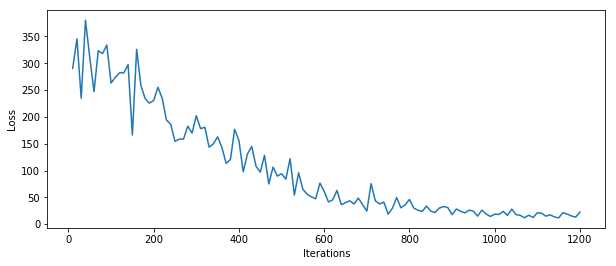

In [37]:
# show_plot(counter,loss_history, save=True)
plt.figure(figsize=(10, 4))
plt.plot(counter,loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig('loss.png')
plt.show()


In [38]:
torch.save(net.state_dict(), "p1b")

In [93]:
testset = LFWDataset(test=True,
                     transform=transforms.Compose([transforms.Scale((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

In [94]:
net.load_state_dict(torch.load('p1b'))

In [95]:
right=wrong=0.

for i, data in enumerate(testloader,0):
    img0, img1, label = data    
    img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
    
    output1, output2 = net(img0,img1)
    dist = F.pairwise_distance(output1, output2)
    print(dist)
    print(label)
    for x,y in zip(dist, label):
        if (x.data[0]>=11 and y.data[0]==1) or (x.data[0]<11 and y.data[0]==0):
            right+=1
        else:
            wrong+=1
    

Variable containing:
 23.3115
 22.4593
 15.0739
 18.3465
 20.3421
 20.1971
 20.5191
 17.4022
 31.8578
 30.3832
 17.6635
 17.6282
 19.6152
 10.2753
 27.9688
 20.2960
 12.7780
 13.5266
 26.1057
 18.3325
 31.3277
 24.3256
 29.6075
 14.3562
 18.1933
 18.5943
 30.5476
 19.5604
 22.8292
 20.4802
 10.0548
 30.3798
 15.9765
  9.7182
 25.8951
 16.4154
 21.4640
 28.9005
 44.3529
 17.1632
 30.4639
 23.4498
 30.1059
 20.3858
 13.0540
 18.3659
 23.7303
 11.3316
 19.2615
 21.3701
 20.7984
 16.8621
 20.0338
 25.9813
 15.1810
 20.0461
 34.3993
 26.6116
  6.3295
  7.4627
 21.1795
 19.4121
 25.5197
 14.8309
[torch.cuda.FloatTensor of size 64x1 (GPU 0)]

Variable containing:
 0
 0
 1
 1
 1
 0
 0
 1
 1
 0
 1
 0
 1
 0
 0
 1
 0
 1
 1
 1
 0
 1
 0
 0
 0
 1
 0
 0
 1
 0
 0
 0
 1
 0
 1
 1
 1
 0
 1
 0
 1
 1
 0
 0
 1
 0
 0
 0
 0
 1
 0
 0
 0
 0
 1
 0
 0
 0
 0
 1
 1
 1
 0
 0
[torch.cuda.LongTensor of size 64 (GPU 0)]



RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503961620703/work/torch/lib/THC/generic/THCStorage.cu:66

In [85]:
#     print(right, wrong)
testacc = right/(right+wrong)
print("Accuracy on test set: {:.2f}".format(testacc))

Accuracy on test set: 0.50


In [86]:
right=wrong=0.

for i, data in enumerate(trainloader,0):
    img0, img1, label = data    
    img0, img1, label = Variable(img0).cuda(), Variable(img1).cuda(), Variable(label).cuda()
    
    output = net(img0,img1)
    for x,y in zip(dist, label):
        if (x.data[0]<=11 and y.data[0]==1) or (x.data[0]>11 and y.data[0]==0):
            right+=1
        else:
            wrong+=1
            

In [87]:
#     print(right, wrong)
trainacc = right/(right+wrong)
print("Accuracy on train set: {:.2f}".format(trainacc))

Accuracy on train set: 0.49


In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.autograd.Variable(torch.randn(3), requires_grad=True)
target = torch.autograd.Variable(torch.FloatTensor(3).random_(2))
print(input, target)
output = loss(m(input), target)
output.backward()

In [ ]:
from PIL import Image
im = Image.open("lfw/Taufik_Hidayat/Taufik_Hidayat_0001.jpg")

plt.imshow(im)

In [ ]:
plt.imshow(data_aug(im))